The first half of this notebook is an implementation of a mixture density network in tensorflow on a synthetic dataset. This example came from: https://www.katnoria.com/mdn/

The second half of this notebook is a reimplementation of CFL_1D_Demonstration.ipynb. The reimplementation depends on core_ml_tf.py instead of core_ml.py. The original file CFL_1D_Demonstration.ipynb has more description on the purpose of each step.

# MDN Example in Tensorflow

In [ ]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Example presented in the PRML book
def create_book_example(n=1000):
    # sample uniformly over the interval (0,1)
    X = np.random.uniform(0., 1., (n,1)).astype(np.float32)    
    # target values 
    y = X + 0.3 * np.sin(2 * np.pi * X) + np.random.uniform(-0.1, 0.1, size=(n,1)).astype(np.float32)
    # test data
    x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)    
    return X, y, x_test

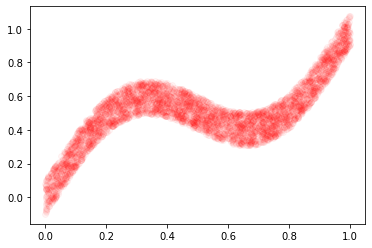

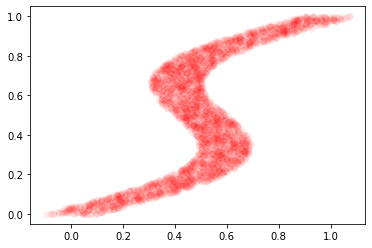

In [20]:
# Plot data (x and y)
X, y, x_test = create_book_example(n=4000)
flipped_x = deepcopy(y)
flipped_y = deepcopy(X)
plt.plot(X, y, 'ro', alpha=0.04)
plt.show()
plt.plot(flipped_x, flipped_y, 'ro', alpha=0.04)
plt.show()

In [21]:
# Load Tensorflow
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
from copy import deepcopy

In [25]:
# In our toy example, we have single input feature
l = 1
# Number of gaussians to represent the multimodal distribution
k = 26

# Network
input = tf.keras.Input(shape=(l,))
layer = tf.keras.layers.Dense(50, activation='tanh', name='baselayer')(input)
mu = tf.keras.layers.Dense((l * k), activation=None, name='mean_layer')(layer)
# variance (should be greater than 0 so we exponentiate it)
var_layer = tf.keras.layers.Dense(k, activation=None, name='dense_var_layer')(layer)
var = tf.keras.layers.Lambda(lambda x: tf.math.exp(x), output_shape=(k,), name='variance_layer')(var_layer)
# mixing coefficient should sum to 1.0
pi = tf.keras.layers.Dense(k, activation='softmax', name='pi_layer')(layer)

In [26]:
model = tf.keras.models.Model(input, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
baselayer (Dense)               (None, 50)           100         input_4[0][0]                    
__________________________________________________________________________________________________
dense_var_layer (Dense)         (None, 26)           1326        baselayer[0][0]                  
__________________________________________________________________________________________________
pi_layer (Dense)                (None, 26)           1326        baselayer[0][0]                  
____________________________________________________________________________________________

In [27]:
# Take a note how easy it is to write the loss function in 
# new tensorflow eager mode (debugging the function becomes intuitive too)

def calc_pdf(y, mu, var):
    """Calculate component density"""
    value = tf.subtract(y, mu)**2
    value = (1/tf.math.sqrt(2 * np.pi * var)) * tf.math.exp((-1/(2*var)) * value)
    return value


def mdn_loss(y_true, pi, mu, var):
    """MDN Loss Function
    The eager mode in tensorflow 2.0 makes is extremely easy to write 
    functions like these. It feels a lot more pythonic to me.
    """
    out = calc_pdf(y_true, mu, var)
    # multiply with each pi and sum it
    out = tf.multiply(out, pi)
    out = tf.reduce_sum(out, 1, keepdims=True)
    out = -tf.math.log(out + 1e-10)
    return tf.reduce_mean(out)

In [28]:
# Use Dataset API to load numpy data (load, shuffle, set batch size)
N = flipped_x.shape[0]
dataset = tf.data.Dataset \
    .from_tensor_slices((flipped_x, flipped_y)) \
    .shuffle(N).batch(N)

In [29]:
@tf.function
def train_step(model, optimizer, train_x, train_y):
    # GradientTape: Trace operations to compute gradients
    with tf.GradientTape() as tape:
        pi_, mu_, var_ = model(train_x, training=True)
        # calculate loss
        loss = mdn_loss(train_y, pi_, mu_, var_)
    # compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [30]:
losses = []
EPOCHS = 6000
print_every = int(0.1 * EPOCHS)

# Define model and optimizer
model = tf.keras.models.Model(input, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()

# Start training
print('Print every {} epochs'.format(print_every))
for i in range(EPOCHS):
    for train_x, train_y in dataset:
        loss = train_step(model, optimizer, train_x, train_y)
        losses.append(loss)
    if i % print_every == 0:
        print('Epoch {}/{}: loss {}'.format(i, EPOCHS, losses[-1]))        

Print every 600 epochs
Epoch 0/6000: loss 1.1386140584945679
Epoch 600/6000: loss -0.8182466626167297
Epoch 1200/6000: loss -0.9584468603134155
Epoch 1800/6000: loss -0.9848271608352661
Epoch 2400/6000: loss -1.00045645236969
Epoch 3000/6000: loss -1.0058187246322632
Epoch 3600/6000: loss -1.0094681978225708
Epoch 4200/6000: loss -1.0171372890472412
Epoch 4800/6000: loss -1.0221784114837646
Epoch 5400/6000: loss -1.0270636081695557


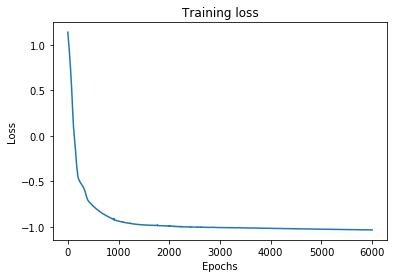

In [31]:
# Let's plot the training loss
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

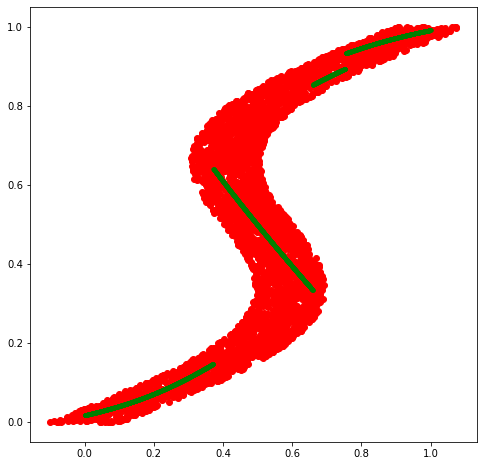

In [32]:
def approx_conditional_mode(pi, var, mu):
    """Approx conditional mode
    Because the conditional mode for MDN does not have simple analytical
    solution, an alternative is to take mean of most probable component 
    at each value of x (PRML, page 277)
    """
    n, k = pi.shape
    out = np.zeros((n, l))
    # Get the index of max pi value for each row
    max_component = tf.argmax(pi, axis=1)
    for i in range(n):
        # The mean value for this index will be used
        mc = max_component[i].numpy()
        for j in range(l):
            out[i, j] = mu[i, mc*(l+j)]
    return out


# Get predictions
pi_vals, mu_vals, var_vals = model.predict(x_test)
pi_vals.shape, mu_vals.shape, var_vals.shape

# Get mean of max(mixing coefficient) of each row
preds = approx_conditional_mode(pi_vals, var_vals, mu_vals)

# Plot along with training data
fig = plt.figure(figsize=(8, 8))
plt.plot(flipped_x, flipped_y, 'ro')
plt.plot(x_test, preds, 'g.')
# plt.plot(flipped_x, preds2, 'b.')
plt.show()

In [33]:
def sample_predictions(pi_vals, mu_vals, var_vals, samples=10):
    n, k = pi_vals.shape
    # print('shape: ', n, k, l)
    # place holder to store the y value for each sample of each row
    out = np.zeros((n, samples, l))
    for i in range(n):
        for j in range(samples):
            # for each sample, use pi/probs to sample the index
            # that will be used to pick up the mu and var values
            idx = np.random.choice(range(k), p=pi_vals[i])
            for li in range(l):
                # Draw random sample from gaussian distribution
                out[i,j,li] = np.random.normal(mu_vals[i, idx*(li+l)], np.sqrt(var_vals[i, idx]))
    return out    

sampled_predictions = sample_predictions(pi_vals, mu_vals, var_vals, 10)

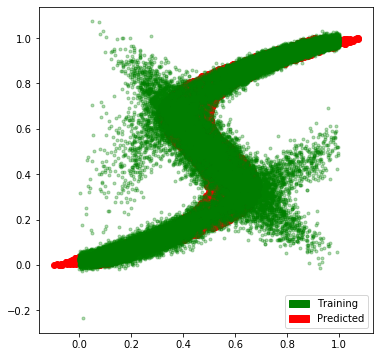

In [34]:
# Plot the predictions along with the flipped data 
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(6, 6))
plt.plot(flipped_x, flipped_y, 'ro', label='train')
for i in range(sampled_predictions.shape[1]):
     plt.plot(x_test, sampled_predictions[:, i], 'g.', alpha=0.3, label='predicted')
patches = [
    mpatches.Patch(color='green', label='Training'),
    mpatches.Patch(color='red', label='Predicted')
]
    
plt.legend(handles=patches)
plt.show()

# MDN on 1D Dataset

In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors

In [2]:
import core_ml_tf as cmt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the data. 
## PLUG YOUR OWN DATA HERE. 'coords' is only needed to display climate maps. Your data
## can only contain X and Y arrays.
X, Y = joblib.load('pair20.pkl')

# Create a randomized, normalized training and validation set.
x_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(Y)
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, shuffle=True, train_size=0.85)
X_tr = x_scaler.transform(X_tr).astype('float32')
Y_tr = y_scaler.transform(Y_tr).astype('float32')
X_ts = x_scaler.transform(X_ts).astype('float32')
Y_ts = y_scaler.transform(Y_ts).astype('float32')
n_features = X_tr.shape[1]
n_components = 4

/Users/imanwahle/anaconda2/envs/jntfpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The file 'pair20.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  after removing the cwd from sys.path.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
nn_layer1 (Dense)               (None, 64)           128         input_layer[0][0]                
__________________________________________________________________________________________________
nn_layer2 (Dense)               (None, 32)           2080        nn_layer1[0][0]                  
__________________________________________________________________________________________________
dense_var_layer (Dense)         (None, 4)            132         nn_layer2[0][0]                  
______________________________________________________________________________________________

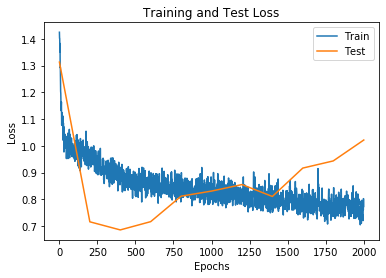

(<tensorflow.python.keras.engine.training.Model at 0x1a3e209e48>,
 <BatchDataset shapes: ((None, 1), (None, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 1), (None, 1)), types: (tf.float32, tf.float32)>)

In [4]:
cmt.train_mixture_density_network(X_tr, Y_tr, X_ts, Y_ts, 
                                  save_fname='checkpoints/epoch_{}', 
                                  n_components=n_components, n_epochs=1001,
                                  lr=1e-3, verbose=True)

In [5]:
model = cmt.get_model(n_features, n_components)
model.load_weights('checkpoints/epoch_400')

In [6]:
density = np.array(
    [cmt.eval_gaussian_mixture(model.predict(np.array([x])), 
                           density_grid=np.linspace(Y.min(), Y.max(),100))
     for x in np.linspace(X.min(), X.max(), 100)])

Text(0.5, 1.0, 'P(y | x)')

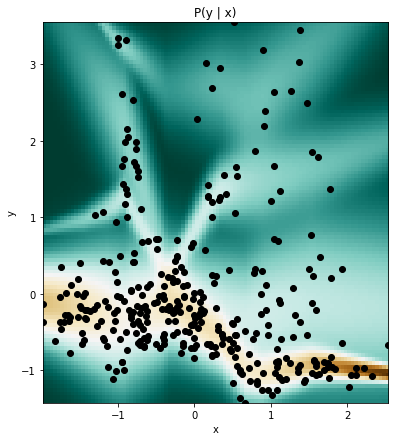

In [8]:
plt.figure(figsize=(7,7), facecolor='white')
plt.imshow(density.T, origin='low', extent=[X.min(), X.max(), Y.min(), Y.max()],
           cmap='BrBG_r', norm=colors.PowerNorm(gamma=1./3.))
plt.plot(X.flatten(), Y.flatten(), 'ko')
plt.xlim([X.min(), X.max()])
plt.ylim([Y.min(), Y.max()])
plt.xlabel('x')
plt.ylabel('y')
plt.title('P(y | x)')

# Observational Partition on X

In [9]:
from sklearn.cluster import KMeans

Text(0.5, 1.0, 'Data colored by causal class of X.')

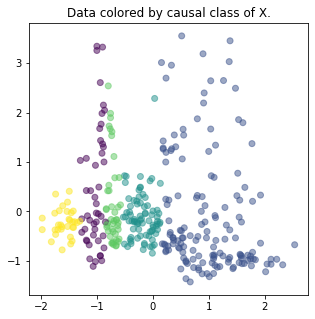

In [10]:
""" Discover the observational classes of X. """

N_CLASSES = 5
p_y_x = np.concatenate(model.predict(X),axis=1)
x_lbls = KMeans(n_clusters=N_CLASSES, n_init=10, n_jobs=-1).fit_predict(p_y_x)
plt.figure(figsize=(5,5), facecolor='white')
plt.scatter(X, Y, c=np.expand_dims(x_lbls,-1), alpha=.5)
plt.title('Data colored by causal class of X.')

# Observational Partition on Y

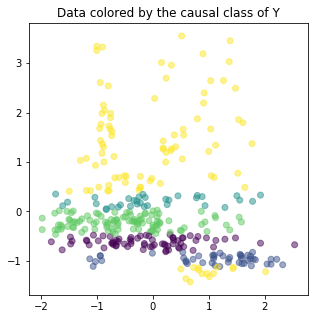

In [17]:
""" Discover the observational classes of Y. """
y_ftrs = np.array(
    [cmt.eval_gaussian_mixture(model.predict(np.array([x])), 
                               density_grid=Y.flatten()) for x in X.flatten()]).T
y_lbls = KMeans(n_clusters=N_CLASSES, n_init=10, n_jobs=-1).fit_predict(y_ftrs)

plt.figure(figsize=(5,5), facecolor='white')
plt.title('Data colored by the causal class of Y')
plt.scatter(X, Y, c=np.expand_dims(y_lbls,-1), alpha=.5)